In [1]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import loggers as pl_loggers
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, RandomCrop, RandomRotation, Normalize

from repath.utils.paths import project_root
import repath.data.datasets.camelyon16 as camelyon16
from repath.preprocess.tissue_detection import TissueDetectorOTSU
from repath.preprocess.patching import GridPatchFinder, SlidesIndex
from repath.preprocess.sampling import split_camelyon16, balanced_sample
from repath.preprocess.patching.apply_transform import ApplyTransforms, SingleTransform, LiuTransform
from torchvision.models import Inception3


In [2]:
experiment_name = "liu"
experiment_root = project_root() / "experiments" / experiment_name
tissue_detector = TissueDetectorOTSU()


In [3]:
train_data = camelyon16.training_small()
apply_transforms = LiuTransform(label = 2, num_transforms = 8)
#apply_transforms = SingleTransform()
patch_finder = GridPatchFinder(labels_level=6, patch_level=0, patch_size=256, stride=256)
#patch_finder = GridPatchFinder(labels_level=7, patch_level=0, patch_size=128, stride=128, apply_transforms= apply_transforms)
train_patches = SlidesIndex.index_dataset(train_data, tissue_detector, patch_finder)


indexing normal_038.tif
indexing tumor_048.tif
indexing normal_058.tif
indexing normal_115.tif
indexing tumor_111.tif
indexing normal_136.tif
indexing tumor_006.tif
indexing tumor_090.tif
indexing normal_129.tif
indexing normal_027.tif
indexing normal_052.tif
indexing normal_082.tif


In [4]:
train_patches

In [5]:
train_patches[0].patches_df

,x,y,label,transform
15310,7680,10240,1,1
15673,2816,10496,1,1
15690,7168,10496,1,1
15692,7680,10496,1,1
15729,17152,10496,1,1
...,...,...,...,...
327423,12544,219392,1,1
327424,12800,219392,1,1
327802,11776,219648,1,1
327803,12032,219648,1,1


In [6]:
import numpy as np
np.unique(train_patches[0].patches_df.label)

array([1])

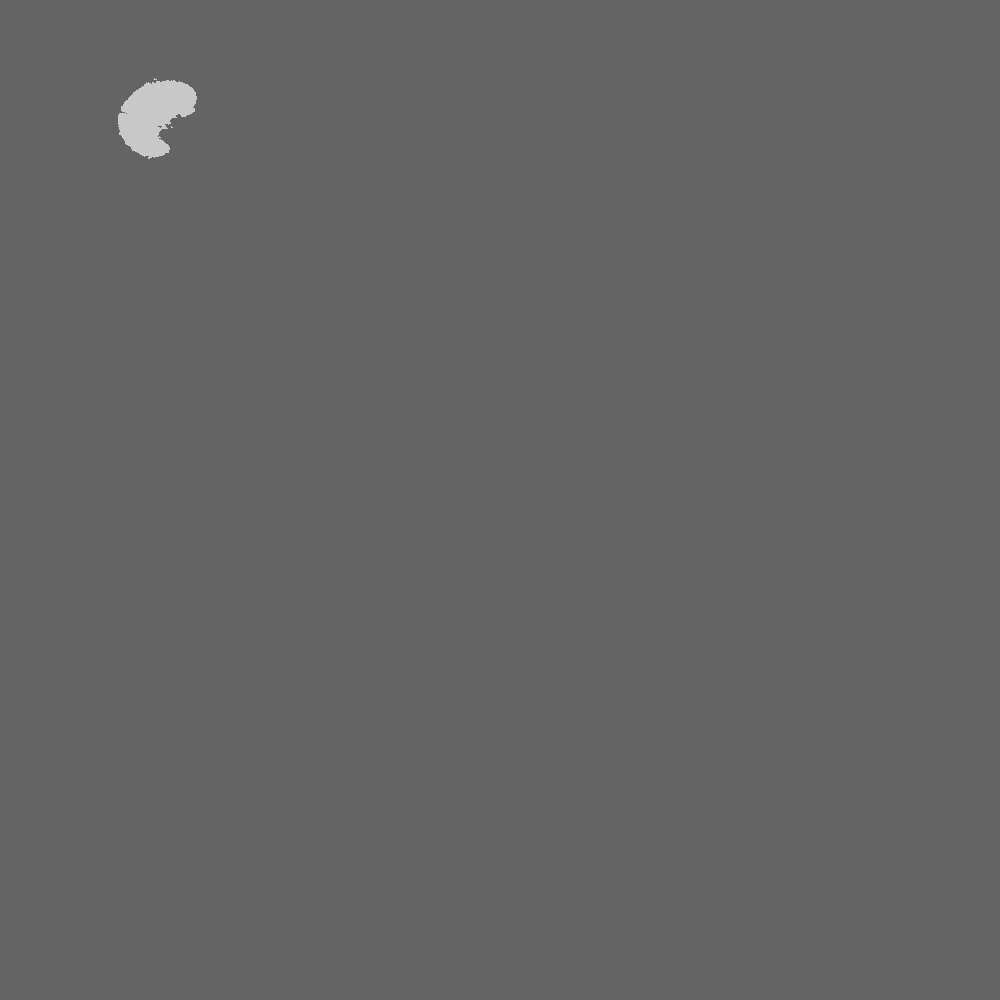

In [7]:
annotation_path = project_root()/ train_data.root/ train_data.paths.annotation.iloc[7]
annotations = train_data.load_annotations(annotation_path)

arr = annotations.render([1000,1000], 256)

from PIL import Image
Image.fromarray(arr.astype('uint8')* 100)


In [8]:
annotation_path

PosixPath('/home/ubuntu/repath/data/camelyon16/raw/training/lesion_annotations/tumor_090.xml')

In [9]:
slide_path = project_root()/ train_data.root/ train_data.paths.slide.iloc[7]
slide = train_data.slide_cls(slide_path) 
slide
#slide_path

In [10]:
labels_shape = slide.dimensions[patch_finder.labels_level].as_shape()
scale_factor = 2 ** patch_finder.labels_level
labels_image = annotations.render(labels_shape, scale_factor)
tissue_mask = tissue_detector(slide.get_thumbnail(patch_finder.labels_level))
labels_image[~tissue_mask] = 0
df, level, size = patch_finder(labels_image)
df

AttributeError: 'NoneType' object has no attribute 'level_dimensions'